# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  0.886132  2.071124  1.0  0.506776 -1.773177 -1.102411  1  0   1.359240   
1 -0.579194  0.787524  1.0  0.036840 -0.476190 -0.776898  0  1   6.330310   
2  0.590995  0.725507  1.0  0.591572 -0.195029 -0.923308  2  0  13.696924   
3 -1.345579  0.103159  1.0  0.733632 -1.455447 -1.188689  0  3  11.952939   
4 -0.056488  1.672058  1.0  0.107557  0.070745 -1.618129  0  2  10.115022   

            y  
0   23.770802  
1   62.168676  
2  219.244009  
3   40.251761  
4  164.536644  
True causal estimate is 12.297061096060709


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

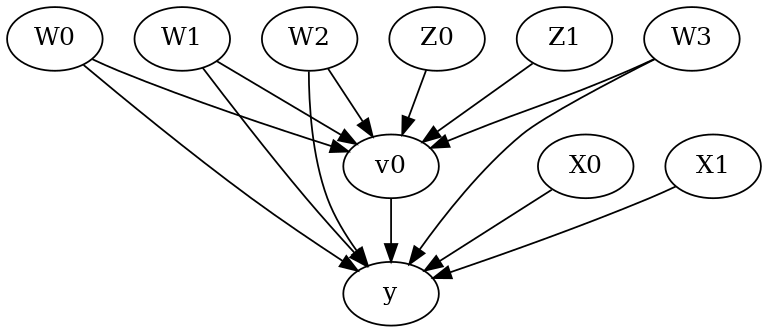

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 12.296987632603136
### Conditional Estimates
__categorical__X0  __categorical__X1           
(-3.984, -1.145]   (-3.0709999999999997, 0.142]    -0.743906
                   (0.142, 0.737]                   2.804578
                   (0.737, 1.239]                   4.808842
                   (1.239, 1.831]                   7.012036
                   (1.831, 5.185]                  10.432833
(-1.145, -0.554]   (-3.0709999999999997, 0.142]     3.682545
                   (0.142, 0.737]                   7.317893
                   (0.737, 1.239]                   9.49912

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

2022-09-06 07:57:29.587141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 07:57:29.587180: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 21.947132110124926
Effect estimates: [20.38506917 16.12220909 19.74220784 16.75223667 22.32774014 23.3585801
 22.18324628 28.5944611  13.73011119 18.8428521  32.91908424 21.58648894
 15.62394475 20.66728145 29.40713153 27.25746701 26.47287621 25.06532367
 25.56046985 23.83840282 22.39396323 10.35671303 21.52544084 28.6817204
 34.74695965 24.86311794 21.62146332 19.66406735 23.17634151 20.93982427
 11.77253126 22.8621147  31.20287696 21.78437514 25.78899663 23.81831075
 17.95935639 27.7553583  15.14609076 16.70247005 26.44525102 20.48588324
  9.090

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 12.297061096060709


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X0,X1
Target units: 

## Estimate
Mean value: 12.333411500716915
Effect estimates: [23.57587219  9.96670175 16.22887891 ... 21.01337666  1.02861318
  5.74065282]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X0,X1
Target units: ate

## Estimate
Mean value: 12.293555830799766
Effect estimates: [23.50766304  9.93210309 16.19426644 ... 20.93895452  1.02837679
  5.73937317]
95.0% confidence interval: (array([23.82685416,  9.85892655, 16.21258733, ..., 21.20421943,
        0.28093295,  5.27244448]), array([24.65214634, 10.1967502 , 16.77646653, ..., 21.96890709,
        1.09218123,  5.92145548]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[14.8033212  15.75703694 12.88137469 14.64104236 13.23894297 15.00918828
 11.87068596 12.01727615 15.54422723 12.23242588]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     2.285369  1.274594  1.0  0.157772 -1.022873  1.482469  1.174728   
1     0.860039  0.202646  1.0  0.141583  1.125318  2.363168 -1.701471   
2    -0.810092  0.176784  0.0  0.828556 -1.935168  1.549639  0.519793   
3    -0.150931 -1.538371  0.0  0.736600  0.043913  0.721501  1.362581   
4    -0.994130 -0.308165  0.0  0.034448  1.480872  0.031113 -0.149983   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.851899 -0.141768  0.0  0.277762 -2.281845  1.584009 -0.829759   
9996  0.740109  0.194862  1.0  0.915561  0.863471  0.606847 -1.869882   
9997 -1.041310 -1.282513  0.0  0.029651 -0.172428 -0.176598 -0.709672   
9998 -0.553778 -0.336865  0.0  0.698264 -1.702197 -0.032931 -2.687462   
9999 -0.944708 -0.987864  0.0  0.328664 -0.025957 -1.563452 -0.664636   

            W3  v0  y  
0    -0.838137   1  1  
1     1.439297   1  1  
2     0.920565   1  1  
3     0.526032   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X0,X1
Target units: ate

## Estimate
Mean value: 0.6399515461310211
Effect estimates: [0.79796612 0.67977946 0.51865902 ... 0.52313768 0.55291011 0.5270632 ]

True causal estimate is 0.4298


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-09-06 08:00:24.510522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-06 08:00:24.514382: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-06 08:00:24.514409: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2e78b96df96a): /proc/driver/nvidia/version does not exist
2022-09-06 08:00:24.514682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:23 - loss: 71.8180

 31/313 [=>............................] - ETA: 0s - loss: 36.6502  

 62/313 [====>.........................] - ETA: 0s - loss: 21.1078

 93/313 [=======>......................] - ETA: 0s - loss: 15.4318

123/313 [==========>...................] - ETA: 0s - loss: 12.5974

154/313 [=============>................] - ETA: 0s - loss: 10.7936

183/313 [================>.............] - ETA: 0s - loss: 9.6529 

212/313 [===================>..........] - ETA: 0s - loss: 8.8184

241/313 [======================>.......] - ETA: 0s - loss: 8.1743

271/313 [========================>.....] - ETA: 0s - loss: 7.6481

302/313 [===========================>..] - ETA: 0s - loss: 7.2134

313/313 [==============================] - 1s 2ms/step - loss: 7.0754


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 3.3547

 32/313 [==>...........................] - ETA: 0s - loss: 3.2675

 61/313 [====>.........................] - ETA: 0s - loss: 3.2554

 91/313 [=======>......................] - ETA: 0s - loss: 3.1977

121/313 [==========>...................] - ETA: 0s - loss: 3.1733

152/313 [=============>................] - ETA: 0s - loss: 3.1501

182/313 [================>.............] - ETA: 0s - loss: 3.1218

212/313 [===================>..........] - ETA: 0s - loss: 3.0928

243/313 [======================>.......] - ETA: 0s - loss: 3.0683

274/313 [=========================>....] - ETA: 0s - loss: 3.0510

304/313 [============================>.] - ETA: 0s - loss: 3.0371

313/313 [==============================] - 1s 2ms/step - loss: 3.0335


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 2.7030

 33/313 [==>...........................] - ETA: 0s - loss: 2.8428

 62/313 [====>.........................] - ETA: 0s - loss: 2.8713

 91/313 [=======>......................] - ETA: 0s - loss: 2.8742

120/313 [==========>...................] - ETA: 0s - loss: 2.8664

149/313 [=============>................] - ETA: 0s - loss: 2.8568

179/313 [================>.............] - ETA: 0s - loss: 2.8544

208/313 [==================>...........] - ETA: 0s - loss: 2.8578

238/313 [=====================>........] - ETA: 0s - loss: 2.8546

268/313 [========================>.....] - ETA: 0s - loss: 2.8482

298/313 [===========================>..] - ETA: 0s - loss: 2.8420

313/313 [==============================] - 1s 2ms/step - loss: 2.8425


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 2.9061

 31/313 [=>............................] - ETA: 0s - loss: 2.7904

 60/313 [====>.........................] - ETA: 0s - loss: 2.7917

 91/313 [=======>......................] - ETA: 0s - loss: 2.8071

121/313 [==========>...................] - ETA: 0s - loss: 2.8063

151/313 [=============>................] - ETA: 0s - loss: 2.8016

181/313 [================>.............] - ETA: 0s - loss: 2.8026

211/313 [===================>..........] - ETA: 0s - loss: 2.7922

242/313 [======================>.......] - ETA: 0s - loss: 2.7899

273/313 [=========================>....] - ETA: 0s - loss: 2.7942

304/313 [============================>.] - ETA: 0s - loss: 2.8017

313/313 [==============================] - 1s 2ms/step - loss: 2.8014


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.8981

 32/313 [==>...........................] - ETA: 0s - loss: 2.8081

 63/313 [=====>........................] - ETA: 0s - loss: 2.8276

 94/313 [========>.....................] - ETA: 0s - loss: 2.8105

125/313 [==========>...................] - ETA: 0s - loss: 2.8020

154/313 [=============>................] - ETA: 0s - loss: 2.7934

184/313 [================>.............] - ETA: 0s - loss: 2.7904

214/313 [===================>..........] - ETA: 0s - loss: 2.7865

245/313 [======================>.......] - ETA: 0s - loss: 2.7856

276/313 [=========================>....] - ETA: 0s - loss: 2.7801

308/313 [============================>.] - ETA: 0s - loss: 2.7782

313/313 [==============================] - 1s 2ms/step - loss: 2.7765


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 2.7583

 32/313 [==>...........................] - ETA: 0s - loss: 2.7605

 63/313 [=====>........................] - ETA: 0s - loss: 2.7731

 94/313 [========>.....................] - ETA: 0s - loss: 2.7702

124/313 [==========>...................] - ETA: 0s - loss: 2.7779

155/313 [=============>................] - ETA: 0s - loss: 2.7706

186/313 [================>.............] - ETA: 0s - loss: 2.7692

217/313 [===================>..........] - ETA: 0s - loss: 2.7612

248/313 [======================>.......] - ETA: 0s - loss: 2.7625

277/313 [=========================>....] - ETA: 0s - loss: 2.7654

308/313 [============================>.] - ETA: 0s - loss: 2.7670

313/313 [==============================] - 1s 2ms/step - loss: 2.7683


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 2.9608

 32/313 [==>...........................] - ETA: 0s - loss: 2.7690

 61/313 [====>.........................] - ETA: 0s - loss: 2.7655

 92/313 [=======>......................] - ETA: 0s - loss: 2.7644

122/313 [==========>...................] - ETA: 0s - loss: 2.7635

152/313 [=============>................] - ETA: 0s - loss: 2.7541

183/313 [================>.............] - ETA: 0s - loss: 2.7540

215/313 [===================>..........] - ETA: 0s - loss: 2.7530

246/313 [======================>.......] - ETA: 0s - loss: 2.7526

276/313 [=========================>....] - ETA: 0s - loss: 2.7495

307/313 [============================>.] - ETA: 0s - loss: 2.7502

313/313 [==============================] - 1s 2ms/step - loss: 2.7473


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.6219

 33/313 [==>...........................] - ETA: 0s - loss: 2.7167

 65/313 [=====>........................] - ETA: 0s - loss: 2.7387

 96/313 [========>.....................] - ETA: 0s - loss: 2.7380

125/313 [==========>...................] - ETA: 0s - loss: 2.7343

155/313 [=============>................] - ETA: 0s - loss: 2.7355

185/313 [================>.............] - ETA: 0s - loss: 2.7295

217/313 [===================>..........] - ETA: 0s - loss: 2.7333

249/313 [======================>.......] - ETA: 0s - loss: 2.7369

280/313 [=========================>....] - ETA: 0s - loss: 2.7351

311/313 [============================>.] - ETA: 0s - loss: 2.7361

313/313 [==============================] - 1s 2ms/step - loss: 2.7353


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.9274

 33/313 [==>...........................] - ETA: 0s - loss: 2.6888

 64/313 [=====>........................] - ETA: 0s - loss: 2.7084

 95/313 [========>.....................] - ETA: 0s - loss: 2.7162

126/313 [===========>..................] - ETA: 0s - loss: 2.7201

157/313 [==============>...............] - ETA: 0s - loss: 2.7146

188/313 [=================>............] - ETA: 0s - loss: 2.7114

218/313 [===================>..........] - ETA: 0s - loss: 2.7189

248/313 [======================>.......] - ETA: 0s - loss: 2.7208

277/313 [=========================>....] - ETA: 0s - loss: 2.7193

307/313 [============================>.] - ETA: 0s - loss: 2.7123

313/313 [==============================] - 1s 2ms/step - loss: 2.7142


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.8659

 32/313 [==>...........................] - ETA: 0s - loss: 2.7179

 63/313 [=====>........................] - ETA: 0s - loss: 2.7379

 93/313 [=======>......................] - ETA: 0s - loss: 2.7340

123/313 [==========>...................] - ETA: 0s - loss: 2.7401

154/313 [=============>................] - ETA: 0s - loss: 2.7287

185/313 [================>.............] - ETA: 0s - loss: 2.7222

215/313 [===================>..........] - ETA: 0s - loss: 2.7162

246/313 [======================>.......] - ETA: 0s - loss: 2.7142

276/313 [=========================>....] - ETA: 0s - loss: 2.7189

306/313 [============================>.] - ETA: 0s - loss: 2.7149

313/313 [==============================] - 1s 2ms/step - loss: 2.7141


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.6679

 31/313 [=>............................] - ETA: 0s - loss: 2.7232

 61/313 [====>.........................] - ETA: 0s - loss: 2.7387

 92/313 [=======>......................] - ETA: 0s - loss: 2.7246

123/313 [==========>...................] - ETA: 0s - loss: 2.7197

153/313 [=============>................] - ETA: 0s - loss: 2.7096

182/313 [================>.............] - ETA: 0s - loss: 2.7014

211/313 [===================>..........] - ETA: 0s - loss: 2.6981

241/313 [======================>.......] - ETA: 0s - loss: 2.6962

271/313 [========================>.....] - ETA: 0s - loss: 2.6899

301/313 [===========================>..] - ETA: 0s - loss: 2.6899

313/313 [==============================] - 1s 2ms/step - loss: 2.6889


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.5583

 31/313 [=>............................] - ETA: 0s - loss: 2.6702

 61/313 [====>.........................] - ETA: 0s - loss: 2.6759

 91/313 [=======>......................] - ETA: 0s - loss: 2.6665

120/313 [==========>...................] - ETA: 0s - loss: 2.6640

151/313 [=============>................] - ETA: 0s - loss: 2.6703

182/313 [================>.............] - ETA: 0s - loss: 2.6763

213/313 [===================>..........] - ETA: 0s - loss: 2.6746

244/313 [======================>.......] - ETA: 0s - loss: 2.6782

274/313 [=========================>....] - ETA: 0s - loss: 2.6767

303/313 [============================>.] - ETA: 0s - loss: 2.6763

313/313 [==============================] - 1s 2ms/step - loss: 2.6786


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.7219

 32/313 [==>...........................] - ETA: 0s - loss: 2.6476

 62/313 [====>.........................] - ETA: 0s - loss: 2.6798

 91/313 [=======>......................] - ETA: 0s - loss: 2.6757

121/313 [==========>...................] - ETA: 0s - loss: 2.6754

151/313 [=============>................] - ETA: 0s - loss: 2.6708

181/313 [================>.............] - ETA: 0s - loss: 2.6657

210/313 [===================>..........] - ETA: 0s - loss: 2.6662

239/313 [=====================>........] - ETA: 0s - loss: 2.6681

268/313 [========================>.....] - ETA: 0s - loss: 2.6666

298/313 [===========================>..] - ETA: 0s - loss: 2.6666

313/313 [==============================] - 1s 2ms/step - loss: 2.6661


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.6114

 32/313 [==>...........................] - ETA: 0s - loss: 2.6813

 63/313 [=====>........................] - ETA: 0s - loss: 2.6531

 94/313 [========>.....................] - ETA: 0s - loss: 2.6644

125/313 [==========>...................] - ETA: 0s - loss: 2.6604

155/313 [=============>................] - ETA: 0s - loss: 2.6657

185/313 [================>.............] - ETA: 0s - loss: 2.6654

215/313 [===================>..........] - ETA: 0s - loss: 2.6640

246/313 [======================>.......] - ETA: 0s - loss: 2.6573

276/313 [=========================>....] - ETA: 0s - loss: 2.6584

307/313 [============================>.] - ETA: 0s - loss: 2.6577

313/313 [==============================] - 1s 2ms/step - loss: 2.6577


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.5258

 32/313 [==>...........................] - ETA: 0s - loss: 2.6416

 63/313 [=====>........................] - ETA: 0s - loss: 2.6385

 94/313 [========>.....................] - ETA: 0s - loss: 2.6463

123/313 [==========>...................] - ETA: 0s - loss: 2.6519

154/313 [=============>................] - ETA: 0s - loss: 2.6501

185/313 [================>.............] - ETA: 0s - loss: 2.6529

216/313 [===================>..........] - ETA: 0s - loss: 2.6534

246/313 [======================>.......] - ETA: 0s - loss: 2.6494

277/313 [=========================>....] - ETA: 0s - loss: 2.6514

308/313 [============================>.] - ETA: 0s - loss: 2.6517

313/313 [==============================] - 1s 2ms/step - loss: 2.6522


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.7871

 32/313 [==>...........................] - ETA: 0s - loss: 2.6560

 62/313 [====>.........................] - ETA: 0s - loss: 2.6628

 92/313 [=======>......................] - ETA: 0s - loss: 2.6572

121/313 [==========>...................] - ETA: 0s - loss: 2.6532

151/313 [=============>................] - ETA: 0s - loss: 2.6492

181/313 [================>.............] - ETA: 0s - loss: 2.6549

203/313 [==================>...........] - ETA: 0s - loss: 2.6528

233/313 [=====================>........] - ETA: 0s - loss: 2.6524

263/313 [========================>.....] - ETA: 0s - loss: 2.6492

294/313 [===========================>..] - ETA: 0s - loss: 2.6517

313/313 [==============================] - 1s 2ms/step - loss: 2.6524


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.5720

 32/313 [==>...........................] - ETA: 0s - loss: 2.6311

 62/313 [====>.........................] - ETA: 0s - loss: 2.6512

 92/313 [=======>......................] - ETA: 0s - loss: 2.6510

123/313 [==========>...................] - ETA: 0s - loss: 2.6527

154/313 [=============>................] - ETA: 0s - loss: 2.6502

183/313 [================>.............] - ETA: 0s - loss: 2.6441

213/313 [===================>..........] - ETA: 0s - loss: 2.6435

244/313 [======================>.......] - ETA: 0s - loss: 2.6479

274/313 [=========================>....] - ETA: 0s - loss: 2.6446

304/313 [============================>.] - ETA: 0s - loss: 2.6427

313/313 [==============================] - 1s 2ms/step - loss: 2.6418


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.4919

 32/313 [==>...........................] - ETA: 0s - loss: 2.6423

 62/313 [====>.........................] - ETA: 0s - loss: 2.6644

 92/313 [=======>......................] - ETA: 0s - loss: 2.6621

123/313 [==========>...................] - ETA: 0s - loss: 2.6529

154/313 [=============>................] - ETA: 0s - loss: 2.6540

184/313 [================>.............] - ETA: 0s - loss: 2.6444

214/313 [===================>..........] - ETA: 0s - loss: 2.6459

244/313 [======================>.......] - ETA: 0s - loss: 2.6458

275/313 [=========================>....] - ETA: 0s - loss: 2.6413

305/313 [============================>.] - ETA: 0s - loss: 2.6402

313/313 [==============================] - 1s 2ms/step - loss: 2.6401


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.5469

 33/313 [==>...........................] - ETA: 0s - loss: 2.6269

 63/313 [=====>........................] - ETA: 0s - loss: 2.6200

 94/313 [========>.....................] - ETA: 0s - loss: 2.6317

126/313 [===========>..................] - ETA: 0s - loss: 2.6429

158/313 [==============>...............] - ETA: 0s - loss: 2.6498

188/313 [=================>............] - ETA: 0s - loss: 2.6475

219/313 [===================>..........] - ETA: 0s - loss: 2.6418

250/313 [======================>.......] - ETA: 0s - loss: 2.6400

281/313 [=========================>....] - ETA: 0s - loss: 2.6400

311/313 [============================>.] - ETA: 0s - loss: 2.6400

313/313 [==============================] - 1s 2ms/step - loss: 2.6406


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 2.5930

 31/313 [=>............................] - ETA: 0s - loss: 2.6483

 62/313 [====>.........................] - ETA: 0s - loss: 2.6533

 94/313 [========>.....................] - ETA: 0s - loss: 2.6413

125/313 [==========>...................] - ETA: 0s - loss: 2.6245

156/313 [=============>................] - ETA: 0s - loss: 2.6330

187/313 [================>.............] - ETA: 0s - loss: 2.6315

219/313 [===================>..........] - ETA: 0s - loss: 2.6339

251/313 [=======================>......] - ETA: 0s - loss: 2.6365

283/313 [==========================>...] - ETA: 0s - loss: 2.6359

313/313 [==============================] - 1s 2ms/step - loss: 2.6346


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.6686

 33/313 [==>...........................] - ETA: 0s - loss: 2.6674

 64/313 [=====>........................] - ETA: 0s - loss: 2.6383

 91/313 [=======>......................] - ETA: 0s - loss: 2.6318

122/313 [==========>...................] - ETA: 0s - loss: 2.6325

153/313 [=============>................] - ETA: 0s - loss: 2.6316

185/313 [================>.............] - ETA: 0s - loss: 2.6315

216/313 [===================>..........] - ETA: 0s - loss: 2.6293

246/313 [======================>.......] - ETA: 0s - loss: 2.6314

277/313 [=========================>....] - ETA: 0s - loss: 2.6293

307/313 [============================>.] - ETA: 0s - loss: 2.6345

313/313 [==============================] - 1s 2ms/step - loss: 2.6329


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.6662

 31/313 [=>............................] - ETA: 0s - loss: 2.6282

 60/313 [====>.........................] - ETA: 0s - loss: 2.6058

 91/313 [=======>......................] - ETA: 0s - loss: 2.6313

122/313 [==========>...................] - ETA: 0s - loss: 2.6360

153/313 [=============>................] - ETA: 0s - loss: 2.6364

184/313 [================>.............] - ETA: 0s - loss: 2.6353

215/313 [===================>..........] - ETA: 0s - loss: 2.6359

246/313 [======================>.......] - ETA: 0s - loss: 2.6350

277/313 [=========================>....] - ETA: 0s - loss: 2.6345

307/313 [============================>.] - ETA: 0s - loss: 2.6345

313/313 [==============================] - 1s 2ms/step - loss: 2.6341


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.5076

 32/313 [==>...........................] - ETA: 0s - loss: 2.6200

 63/313 [=====>........................] - ETA: 0s - loss: 2.6145

 94/313 [========>.....................] - ETA: 0s - loss: 2.6238

125/313 [==========>...................] - ETA: 0s - loss: 2.6318

154/313 [=============>................] - ETA: 0s - loss: 2.6302

184/313 [================>.............] - ETA: 0s - loss: 2.6318

215/313 [===================>..........] - ETA: 0s - loss: 2.6283

245/313 [======================>.......] - ETA: 0s - loss: 2.6286

269/313 [========================>.....] - ETA: 0s - loss: 2.6278

297/313 [===========================>..] - ETA: 0s - loss: 2.6286

313/313 [==============================] - 1s 2ms/step - loss: 2.6329


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 2.4370

 32/313 [==>...........................] - ETA: 0s - loss: 2.6499

 63/313 [=====>........................] - ETA: 0s - loss: 2.6418

 94/313 [========>.....................] - ETA: 0s - loss: 2.6234

125/313 [==========>...................] - ETA: 0s - loss: 2.6239

156/313 [=============>................] - ETA: 0s - loss: 2.6186

187/313 [================>.............] - ETA: 0s - loss: 2.6246

216/313 [===================>..........] - ETA: 0s - loss: 2.6327

246/313 [======================>.......] - ETA: 0s - loss: 2.6328

276/313 [=========================>....] - ETA: 0s - loss: 2.6298

307/313 [============================>.] - ETA: 0s - loss: 2.6329

313/313 [==============================] - 1s 2ms/step - loss: 2.6311


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2.6788

 33/313 [==>...........................] - ETA: 0s - loss: 2.6223

 65/313 [=====>........................] - ETA: 0s - loss: 2.6145

 96/313 [========>.....................] - ETA: 0s - loss: 2.6309

126/313 [===========>..................] - ETA: 0s - loss: 2.6397

157/313 [==============>...............] - ETA: 0s - loss: 2.6302

188/313 [=================>............] - ETA: 0s - loss: 2.6251

219/313 [===================>..........] - ETA: 0s - loss: 2.6258

249/313 [======================>.......] - ETA: 0s - loss: 2.6272

280/313 [=========================>....] - ETA: 0s - loss: 2.6256

311/313 [============================>.] - ETA: 0s - loss: 2.6296

313/313 [==============================] - 1s 2ms/step - loss: 2.6299


Epoch 1/25


  1/313 [..............................] - ETA: 3:54 - loss: 55818.0000

 26/313 [=>............................] - ETA: 0s - loss: 55228.0391  

 51/313 [===>..........................] - ETA: 0s - loss: 49992.0039

 76/313 [======>.......................] - ETA: 0s - loss: 45196.8711

101/313 [========>.....................] - ETA: 0s - loss: 41600.7734

126/313 [===========>..................] - ETA: 0s - loss: 39020.2461

151/313 [=============>................] - ETA: 0s - loss: 37311.4570

175/313 [===============>..............] - ETA: 0s - loss: 35776.8555

200/313 [==================>...........] - ETA: 0s - loss: 34553.1758

225/313 [====================>.........] - ETA: 0s - loss: 33491.1016

250/313 [======================>.......] - ETA: 0s - loss: 32397.9297

275/313 [=========================>....] - ETA: 0s - loss: 31375.3340

300/313 [===========================>..] - ETA: 0s - loss: 30389.8027

313/313 [==============================] - 1s 2ms/step - loss: 30036.6934


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 19031.9355

 25/313 [=>............................] - ETA: 0s - loss: 18458.8672

 50/313 [===>..........................] - ETA: 0s - loss: 18135.4766

 75/313 [======>.......................] - ETA: 0s - loss: 17927.9277

100/313 [========>.....................] - ETA: 0s - loss: 17915.1914

125/313 [==========>...................] - ETA: 0s - loss: 18065.6582

150/313 [=============>................] - ETA: 0s - loss: 17771.6816

175/313 [===============>..............] - ETA: 0s - loss: 17524.7695

200/313 [==================>...........] - ETA: 0s - loss: 17593.8008

225/313 [====================>.........] - ETA: 0s - loss: 17571.9824

251/313 [=======================>......] - ETA: 0s - loss: 17672.1523

275/313 [=========================>....] - ETA: 0s - loss: 17726.5527

298/313 [===========================>..] - ETA: 0s - loss: 17641.7676

313/313 [==============================] - 1s 2ms/step - loss: 17621.6641


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 14277.5039

 27/313 [=>............................] - ETA: 0s - loss: 14836.6689

 52/313 [===>..........................] - ETA: 0s - loss: 16339.8643

 77/313 [======>.......................] - ETA: 0s - loss: 16995.3848

101/313 [========>.....................] - ETA: 0s - loss: 16700.7520

125/313 [==========>...................] - ETA: 0s - loss: 17076.0273

149/313 [=============>................] - ETA: 0s - loss: 17039.6133

173/313 [===============>..............] - ETA: 0s - loss: 16905.3438

198/313 [=================>............] - ETA: 0s - loss: 16971.1445

224/313 [====================>.........] - ETA: 0s - loss: 16873.9668

250/313 [======================>.......] - ETA: 0s - loss: 16922.0566

275/313 [=========================>....] - ETA: 0s - loss: 17103.6953

300/313 [===========================>..] - ETA: 0s - loss: 17246.6758

313/313 [==============================] - 1s 2ms/step - loss: 17139.2383


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 14769.4453

 26/313 [=>............................] - ETA: 0s - loss: 15897.0693

 51/313 [===>..........................] - ETA: 0s - loss: 16701.5586

 76/313 [======>.......................] - ETA: 0s - loss: 17360.5645

101/313 [========>.....................] - ETA: 0s - loss: 17234.2461

126/313 [===========>..................] - ETA: 0s - loss: 17144.9824

150/313 [=============>................] - ETA: 0s - loss: 17072.4258

174/313 [===============>..............] - ETA: 0s - loss: 17208.9023

197/313 [=================>............] - ETA: 0s - loss: 16954.8613

223/313 [====================>.........] - ETA: 0s - loss: 16968.4668

248/313 [======================>.......] - ETA: 0s - loss: 17125.5234

273/313 [=========================>....] - ETA: 0s - loss: 17103.3125

298/313 [===========================>..] - ETA: 0s - loss: 16981.7227

313/313 [==============================] - 1s 2ms/step - loss: 16985.0996


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 18375.4609

 27/313 [=>............................] - ETA: 0s - loss: 16480.1074

 52/313 [===>..........................] - ETA: 0s - loss: 17018.6465

 78/313 [======>.......................] - ETA: 0s - loss: 17057.8535

103/313 [========>.....................] - ETA: 0s - loss: 16723.4062

128/313 [===========>..................] - ETA: 0s - loss: 17096.5645

153/313 [=============>................] - ETA: 0s - loss: 17239.0801

178/313 [================>.............] - ETA: 0s - loss: 17334.8496

204/313 [==================>...........] - ETA: 0s - loss: 17143.6562

230/313 [=====================>........] - ETA: 0s - loss: 17110.9785

255/313 [=======================>......] - ETA: 0s - loss: 17113.3633

281/313 [=========================>....] - ETA: 0s - loss: 16822.7773

306/313 [============================>.] - ETA: 0s - loss: 16814.4316

313/313 [==============================] - 1s 2ms/step - loss: 16854.6543


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 25413.2617

 28/313 [=>............................] - ETA: 0s - loss: 17721.6074

 54/313 [====>.........................] - ETA: 0s - loss: 17028.0859

 80/313 [======>.......................] - ETA: 0s - loss: 17101.7969

105/313 [=========>....................] - ETA: 0s - loss: 16651.5293

131/313 [===========>..................] - ETA: 0s - loss: 16768.1484

157/313 [==============>...............] - ETA: 0s - loss: 16967.3477

182/313 [================>.............] - ETA: 0s - loss: 16833.9531

207/313 [==================>...........] - ETA: 0s - loss: 16637.8633

233/313 [=====================>........] - ETA: 0s - loss: 16520.3359

259/313 [=======================>......] - ETA: 0s - loss: 16608.7578

285/313 [==========================>...] - ETA: 0s - loss: 16681.8008

310/313 [============================>.] - ETA: 0s - loss: 16822.0586

313/313 [==============================] - 1s 2ms/step - loss: 16841.9863


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 14952.0859

 27/313 [=>............................] - ETA: 0s - loss: 17473.2051

 53/313 [====>.........................] - ETA: 0s - loss: 17476.8887

 79/313 [======>.......................] - ETA: 0s - loss: 17156.4902

104/313 [========>.....................] - ETA: 0s - loss: 17543.5273

130/313 [===========>..................] - ETA: 0s - loss: 17149.8633

155/313 [=============>................] - ETA: 0s - loss: 17062.5488

180/313 [================>.............] - ETA: 0s - loss: 17192.7617

207/313 [==================>...........] - ETA: 0s - loss: 17042.5234

233/313 [=====================>........] - ETA: 0s - loss: 17107.1387

258/313 [=======================>......] - ETA: 0s - loss: 16823.6836

284/313 [==========================>...] - ETA: 0s - loss: 16674.7969

310/313 [============================>.] - ETA: 0s - loss: 16694.2422

313/313 [==============================] - 1s 2ms/step - loss: 16744.7070


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 14648.6660

 26/313 [=>............................] - ETA: 0s - loss: 16891.3691

 51/313 [===>..........................] - ETA: 0s - loss: 17156.3438

 76/313 [======>.......................] - ETA: 0s - loss: 16982.8340

100/313 [========>.....................] - ETA: 0s - loss: 16978.8535

124/313 [==========>...................] - ETA: 0s - loss: 16575.4980

150/313 [=============>................] - ETA: 0s - loss: 16195.7852

176/313 [===============>..............] - ETA: 0s - loss: 16422.8906

201/313 [==================>...........] - ETA: 0s - loss: 16568.3984

227/313 [====================>.........] - ETA: 0s - loss: 16659.4688

252/313 [=======================>......] - ETA: 0s - loss: 16677.4512

277/313 [=========================>....] - ETA: 0s - loss: 16745.8867

302/313 [===========================>..] - ETA: 0s - loss: 16726.4043

313/313 [==============================] - 1s 2ms/step - loss: 16755.4570


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 16725.3379

 25/313 [=>............................] - ETA: 0s - loss: 16734.4316

 50/313 [===>..........................] - ETA: 0s - loss: 16322.3564

 75/313 [======>.......................] - ETA: 0s - loss: 16698.4551

100/313 [========>.....................] - ETA: 0s - loss: 16513.3711

126/313 [===========>..................] - ETA: 0s - loss: 16659.9824

151/313 [=============>................] - ETA: 0s - loss: 16466.3535

176/313 [===============>..............] - ETA: 0s - loss: 16271.9658

202/313 [==================>...........] - ETA: 0s - loss: 16435.7188

228/313 [====================>.........] - ETA: 0s - loss: 16488.7324

254/313 [=======================>......] - ETA: 0s - loss: 16386.0352

279/313 [=========================>....] - ETA: 0s - loss: 16441.8633

304/313 [============================>.] - ETA: 0s - loss: 16526.2910

313/313 [==============================] - 1s 2ms/step - loss: 16628.0020


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 12470.0830

 27/313 [=>............................] - ETA: 0s - loss: 17582.6953

 53/313 [====>.........................] - ETA: 0s - loss: 18192.2969

 78/313 [======>.......................] - ETA: 0s - loss: 17174.2520

103/313 [========>.....................] - ETA: 0s - loss: 17034.1250

129/313 [===========>..................] - ETA: 0s - loss: 16983.2051

154/313 [=============>................] - ETA: 0s - loss: 16698.2402

179/313 [================>.............] - ETA: 0s - loss: 16700.3750

204/313 [==================>...........] - ETA: 0s - loss: 16784.8828

230/313 [=====================>........] - ETA: 0s - loss: 16685.4316

254/313 [=======================>......] - ETA: 0s - loss: 16757.6348

279/313 [=========================>....] - ETA: 0s - loss: 16683.4668

303/313 [============================>.] - ETA: 0s - loss: 16526.4043

313/313 [==============================] - 1s 2ms/step - loss: 16599.6523


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 24326.0508

 26/313 [=>............................] - ETA: 0s - loss: 17283.9609

 51/313 [===>..........................] - ETA: 0s - loss: 17020.0938

 76/313 [======>.......................] - ETA: 0s - loss: 16718.5840

102/313 [========>.....................] - ETA: 0s - loss: 16636.3672

127/313 [===========>..................] - ETA: 0s - loss: 16724.2266

152/313 [=============>................] - ETA: 0s - loss: 16740.0840

178/313 [================>.............] - ETA: 0s - loss: 16728.8672

204/313 [==================>...........] - ETA: 0s - loss: 16752.4980

229/313 [====================>.........] - ETA: 0s - loss: 16609.0234

255/313 [=======================>......] - ETA: 0s - loss: 16713.4863

281/313 [=========================>....] - ETA: 0s - loss: 16627.1289

307/313 [============================>.] - ETA: 0s - loss: 16652.9355

313/313 [==============================] - 1s 2ms/step - loss: 16585.8672


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 8101.5518

 26/313 [=>............................] - ETA: 0s - loss: 16850.4746

 51/313 [===>..........................] - ETA: 0s - loss: 15613.8398

 76/313 [======>.......................] - ETA: 0s - loss: 16320.4258

101/313 [========>.....................] - ETA: 0s - loss: 16673.4531

124/313 [==========>...................] - ETA: 0s - loss: 16764.7246

148/313 [=============>................] - ETA: 0s - loss: 16718.8242

172/313 [===============>..............] - ETA: 0s - loss: 16898.5820

196/313 [=================>............] - ETA: 0s - loss: 16850.3418

221/313 [====================>.........] - ETA: 0s - loss: 16775.4082

246/313 [======================>.......] - ETA: 0s - loss: 16756.4062

271/313 [========================>.....] - ETA: 0s - loss: 16678.8125

296/313 [===========================>..] - ETA: 0s - loss: 16723.6660

313/313 [==============================] - 1s 2ms/step - loss: 16646.1934


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 31903.7656

 26/313 [=>............................] - ETA: 0s - loss: 15684.3643

 52/313 [===>..........................] - ETA: 0s - loss: 16167.2539

 77/313 [======>.......................] - ETA: 0s - loss: 15861.3115

102/313 [========>.....................] - ETA: 0s - loss: 15615.5801

127/313 [===========>..................] - ETA: 0s - loss: 15717.9893

152/313 [=============>................] - ETA: 0s - loss: 15805.9043

177/313 [===============>..............] - ETA: 0s - loss: 15836.8838

202/313 [==================>...........] - ETA: 0s - loss: 16018.5361

228/313 [====================>.........] - ETA: 0s - loss: 16120.2490

253/313 [=======================>......] - ETA: 0s - loss: 16529.0352

277/313 [=========================>....] - ETA: 0s - loss: 16629.6035

301/313 [===========================>..] - ETA: 0s - loss: 16563.9082

313/313 [==============================] - 1s 2ms/step - loss: 16644.9336


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 18966.1387

 26/313 [=>............................] - ETA: 0s - loss: 17234.2734

 51/313 [===>..........................] - ETA: 0s - loss: 16524.9258

 76/313 [======>.......................] - ETA: 0s - loss: 16443.0156

100/313 [========>.....................] - ETA: 0s - loss: 16827.1191

124/313 [==========>...................] - ETA: 0s - loss: 16884.3672

149/313 [=============>................] - ETA: 0s - loss: 16818.1562

174/313 [===============>..............] - ETA: 0s - loss: 16572.8926

199/313 [==================>...........] - ETA: 0s - loss: 16570.3965

224/313 [====================>.........] - ETA: 0s - loss: 16587.5820

250/313 [======================>.......] - ETA: 0s - loss: 16594.1895

274/313 [=========================>....] - ETA: 0s - loss: 16496.4746

299/313 [===========================>..] - ETA: 0s - loss: 16598.1738

313/313 [==============================] - 1s 2ms/step - loss: 16629.9062


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 10525.7275

 26/313 [=>............................] - ETA: 0s - loss: 16597.2715

 51/313 [===>..........................] - ETA: 0s - loss: 17798.4238

 75/313 [======>.......................] - ETA: 0s - loss: 17179.5898

100/313 [========>.....................] - ETA: 0s - loss: 16715.6055

124/313 [==========>...................] - ETA: 0s - loss: 16615.2520

148/313 [=============>................] - ETA: 0s - loss: 16372.2822

172/313 [===============>..............] - ETA: 0s - loss: 16236.2773

197/313 [=================>............] - ETA: 0s - loss: 16097.9053

222/313 [====================>.........] - ETA: 0s - loss: 16158.6152

247/313 [======================>.......] - ETA: 0s - loss: 16162.5029

272/313 [=========================>....] - ETA: 0s - loss: 16227.5752

297/313 [===========================>..] - ETA: 0s - loss: 16382.4297

313/313 [==============================] - 1s 2ms/step - loss: 16344.2363


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 13580.3564

 26/313 [=>............................] - ETA: 0s - loss: 16672.0645

 51/313 [===>..........................] - ETA: 0s - loss: 16519.7227

 75/313 [======>.......................] - ETA: 0s - loss: 16732.6348

100/313 [========>.....................] - ETA: 0s - loss: 16902.0391

125/313 [==========>...................] - ETA: 0s - loss: 16581.9453

151/313 [=============>................] - ETA: 0s - loss: 16590.1035

177/313 [===============>..............] - ETA: 0s - loss: 16489.8672

202/313 [==================>...........] - ETA: 0s - loss: 16590.8945

227/313 [====================>.........] - ETA: 0s - loss: 16461.6738

252/313 [=======================>......] - ETA: 0s - loss: 16627.0840

277/313 [=========================>....] - ETA: 0s - loss: 16777.9219

302/313 [===========================>..] - ETA: 0s - loss: 16628.0059

313/313 [==============================] - 1s 2ms/step - loss: 16716.4512


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 14747.8203

 26/313 [=>............................] - ETA: 0s - loss: 16134.8223

 50/313 [===>..........................] - ETA: 0s - loss: 17321.9551

 75/313 [======>.......................] - ETA: 0s - loss: 16682.0859

100/313 [========>.....................] - ETA: 0s - loss: 16602.7402

125/313 [==========>...................] - ETA: 0s - loss: 16595.4004

150/313 [=============>................] - ETA: 0s - loss: 16745.5879

175/313 [===============>..............] - ETA: 0s - loss: 16716.9492

200/313 [==================>...........] - ETA: 0s - loss: 16945.8848

225/313 [====================>.........] - ETA: 0s - loss: 17049.3887

250/313 [======================>.......] - ETA: 0s - loss: 16937.4336

275/313 [=========================>....] - ETA: 0s - loss: 16963.2715

300/313 [===========================>..] - ETA: 0s - loss: 16847.2832

313/313 [==============================] - 1s 2ms/step - loss: 16750.2246


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 20776.8535

 27/313 [=>............................] - ETA: 0s - loss: 17636.1719

 51/313 [===>..........................] - ETA: 0s - loss: 17370.8516

 76/313 [======>.......................] - ETA: 0s - loss: 17470.6543

101/313 [========>.....................] - ETA: 0s - loss: 17054.1680

126/313 [===========>..................] - ETA: 0s - loss: 17085.5859

151/313 [=============>................] - ETA: 0s - loss: 16933.4297

176/313 [===============>..............] - ETA: 0s - loss: 17003.1328

201/313 [==================>...........] - ETA: 0s - loss: 16769.8379

225/313 [====================>.........] - ETA: 0s - loss: 16521.2559

249/313 [======================>.......] - ETA: 0s - loss: 16529.6680

273/313 [=========================>....] - ETA: 0s - loss: 16588.8477

298/313 [===========================>..] - ETA: 0s - loss: 16671.0195

313/313 [==============================] - 1s 2ms/step - loss: 16569.0918


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 21414.1523

 26/313 [=>............................] - ETA: 0s - loss: 17784.1113

 50/313 [===>..........................] - ETA: 0s - loss: 16809.6953

 74/313 [======>.......................] - ETA: 0s - loss: 16202.3379

 99/313 [========>.....................] - ETA: 0s - loss: 16537.4531

124/313 [==========>...................] - ETA: 0s - loss: 16306.6221

149/313 [=============>................] - ETA: 0s - loss: 16259.6260

173/313 [===============>..............] - ETA: 0s - loss: 16436.7090

197/313 [=================>............] - ETA: 0s - loss: 16577.5566

222/313 [====================>.........] - ETA: 0s - loss: 16695.8926

247/313 [======================>.......] - ETA: 0s - loss: 16598.3398

272/313 [=========================>....] - ETA: 0s - loss: 16707.0566

297/313 [===========================>..] - ETA: 0s - loss: 16643.6211

313/313 [==============================] - 1s 2ms/step - loss: 16578.3555


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 9069.4482

 27/313 [=>............................] - ETA: 0s - loss: 18052.0801

 52/313 [===>..........................] - ETA: 0s - loss: 17993.2188

 77/313 [======>.......................] - ETA: 0s - loss: 17749.4277

102/313 [========>.....................] - ETA: 0s - loss: 17643.0996

127/313 [===========>..................] - ETA: 0s - loss: 17746.4922

152/313 [=============>................] - ETA: 0s - loss: 17225.1348

177/313 [===============>..............] - ETA: 0s - loss: 17103.2012

202/313 [==================>...........] - ETA: 0s - loss: 16897.1973

227/313 [====================>.........] - ETA: 0s - loss: 16958.0645

252/313 [=======================>......] - ETA: 0s - loss: 16861.0508

277/313 [=========================>....] - ETA: 0s - loss: 16679.5586

303/313 [============================>.] - ETA: 0s - loss: 16600.8672

313/313 [==============================] - 1s 2ms/step - loss: 16519.8379


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 30710.1094

 26/313 [=>............................] - ETA: 0s - loss: 16814.2227

 51/313 [===>..........................] - ETA: 0s - loss: 18045.7832

 76/313 [======>.......................] - ETA: 0s - loss: 16997.4629

100/313 [========>.....................] - ETA: 0s - loss: 16931.1914

125/313 [==========>...................] - ETA: 0s - loss: 17050.0898

150/313 [=============>................] - ETA: 0s - loss: 16953.4121

174/313 [===============>..............] - ETA: 0s - loss: 16932.0273

199/313 [==================>...........] - ETA: 0s - loss: 16859.2422

222/313 [====================>.........] - ETA: 0s - loss: 16994.7910

246/313 [======================>.......] - ETA: 0s - loss: 17057.9141

271/313 [========================>.....] - ETA: 0s - loss: 16938.3535

296/313 [===========================>..] - ETA: 0s - loss: 16970.6152

313/313 [==============================] - 1s 2ms/step - loss: 16821.4082


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 18700.6523

 26/313 [=>............................] - ETA: 0s - loss: 17314.2051

 51/313 [===>..........................] - ETA: 0s - loss: 16662.7754

 76/313 [======>.......................] - ETA: 0s - loss: 16972.3867

100/313 [========>.....................] - ETA: 0s - loss: 16938.8594

125/313 [==========>...................] - ETA: 0s - loss: 17041.8652

149/313 [=============>................] - ETA: 0s - loss: 17135.9082

173/313 [===============>..............] - ETA: 0s - loss: 17191.9395

197/313 [=================>............] - ETA: 0s - loss: 17073.4883

221/313 [====================>.........] - ETA: 0s - loss: 16973.7520

245/313 [======================>.......] - ETA: 0s - loss: 16874.9180

270/313 [========================>.....] - ETA: 0s - loss: 16716.3145

295/313 [===========================>..] - ETA: 0s - loss: 16756.3633

313/313 [==============================] - 1s 2ms/step - loss: 16809.3730


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 10584.7070

 27/313 [=>............................] - ETA: 0s - loss: 17280.8418

 52/313 [===>..........................] - ETA: 0s - loss: 17003.0020

 77/313 [======>.......................] - ETA: 0s - loss: 17034.6523

102/313 [========>.....................] - ETA: 0s - loss: 16962.0645

127/313 [===========>..................] - ETA: 0s - loss: 16678.0918

152/313 [=============>................] - ETA: 0s - loss: 16661.5977

178/313 [================>.............] - ETA: 0s - loss: 16361.7021

203/313 [==================>...........] - ETA: 0s - loss: 16554.1777

228/313 [====================>.........] - ETA: 0s - loss: 16532.4688

253/313 [=======================>......] - ETA: 0s - loss: 16438.8418

278/313 [=========================>....] - ETA: 0s - loss: 16453.6113

304/313 [============================>.] - ETA: 0s - loss: 16428.5820

313/313 [==============================] - 1s 2ms/step - loss: 16367.6865


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 17908.2891

 26/313 [=>............................] - ETA: 0s - loss: 15955.7021

 50/313 [===>..........................] - ETA: 0s - loss: 15841.1973

 75/313 [======>.......................] - ETA: 0s - loss: 16154.3320

100/313 [========>.....................] - ETA: 0s - loss: 15761.9023

125/313 [==========>...................] - ETA: 0s - loss: 16485.6270

150/313 [=============>................] - ETA: 0s - loss: 16565.4062

174/313 [===============>..............] - ETA: 0s - loss: 16546.2129

199/313 [==================>...........] - ETA: 0s - loss: 16596.0234

224/313 [====================>.........] - ETA: 0s - loss: 16637.0508

249/313 [======================>.......] - ETA: 0s - loss: 16575.7891

274/313 [=========================>....] - ETA: 0s - loss: 16457.0664

299/313 [===========================>..] - ETA: 0s - loss: 16460.6562

313/313 [==============================] - 1s 2ms/step - loss: 16551.3730


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 11721.5830

 27/313 [=>............................] - ETA: 0s - loss: 15422.8271

 53/313 [====>.........................] - ETA: 0s - loss: 16644.5918

 78/313 [======>.......................] - ETA: 0s - loss: 16745.0762

103/313 [========>.....................] - ETA: 0s - loss: 16222.5684

128/313 [===========>..................] - ETA: 0s - loss: 16557.7129

153/313 [=============>................] - ETA: 0s - loss: 16801.4668

178/313 [================>.............] - ETA: 0s - loss: 16945.2090

203/313 [==================>...........] - ETA: 0s - loss: 16929.3926

228/313 [====================>.........] - ETA: 0s - loss: 16799.6172

252/313 [=======================>......] - ETA: 0s - loss: 16728.2715

277/313 [=========================>....] - ETA: 0s - loss: 16663.0723

302/313 [===========================>..] - ETA: 0s - loss: 16716.1367

313/313 [==============================] - 1s 2ms/step - loss: 16636.4004


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/237 [..............................] - ETA: 18s

 58/237 [======>.......................] - ETA: 0s 

116/237 [=============>................] - ETA: 0s

176/237 [=====================>........] - ETA: 0s

236/237 [============================>.] - ETA: 0s

237/237 [==============================] - 0s 869us/step


  1/237 [..............................] - ETA: 3s

 55/237 [=====>........................] - ETA: 0s

113/237 [=============>................] - ETA: 0s

171/237 [====================>.........] - ETA: 0s

229/237 [===========================>..] - ETA: 0s

237/237 [==============================] - 0s 888us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 0.3455266058444977
Effect estimates: [ 0.60372925 -0.04951477  0.61650085 ...  0.27372742  0.37127686
  0.5234451 ]


### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     0.477160  1.133365 -1.571750  1.090406 -0.508599  0.0  0.818624   
1     0.355581  0.834153 -0.360356  1.139220  1.190741  1.0  0.379463   
2    -0.832481  0.074416 -0.980024  1.847816  0.916605  0.0  0.038398   
3    -1.326943 -1.451908  0.473396  0.720793 -0.570464  0.0  0.081894   
4     0.240096  1.073867 -0.088420 -0.150974  0.732353  0.0  0.283297   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -0.356285  0.123051 -3.376941  3.165045  0.469199  0.0  0.428603   
9996 -0.570418 -0.692534  0.488485  1.876414 -0.853857  0.0  0.076491   
9997 -1.554232  0.307591 -0.364930  1.423087  1.308061  1.0  0.619830   
9998  0.623522  0.045960 -2.441482 -0.895511 -1.680821  1.0  0.833010   
9999  2.337414  0.649883 -1.306042 -0.357194 -0.355055  1.0  0.905127   

            W0        W1        W2        W3        W4  v0          y  
0    -1.092867 -1.937398  0.332545 -1.471030 -0.265

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W2,W0,W1,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,W4,U) = P(y|v0,W3,W2,W0,W1,W4)

## Realized estimand
b: y~v0+X4+X3+X0+X2+X1+W3+W2+W0+W1+W4
Target units: ate

## Estimate
Mean value: 9.314421605003936
Effect estimates: [16.54895625 19.73694927 10.85449788 ... 12.81923058 -2.48635047
 16.87306547]

True causal estimate is 7.270712742518023


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W2,W0,W1,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,W4,U) = P(y|v0,W3,W2,W0,W1,W4)

## Realized estimand
b: y~v0+X4+X3+X0+X2+X1+W3+W2+W0+W1+W4
Target units: Data subset provided as a data frame

## Estimate
Mean value: 9.115376149053889
Effect estimates: [ 3.66596546 17.9873001  18.14557034 -4.63261272 10.41065756]

True causal estimate is 7.270712742518023


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:13.799552166277318
New effect:13.76745717074645
p value:0.76



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:13.799552166277318
New effect:13.666119373757292



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:13.799552166277318
New effect:-0.007202396253376065
p value:0.4672192903246035



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:13.799552166277318
New effect:13.751930864041878
p value:0.28320314875129726



More refutation methods to come, especially specific to the CATE estimators.